# Create a User Defined Fitter using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales and Zé Vinícius.

## Learning Goals
* Know and understand tools to make user defined fitters with `astropy`
* Learn custom fitters
* This tutorial assumes the student knows how to fit data using `astropy.modeling`. Check the tutorial [Make a Quick Fit Using astropy.modeling](https://astropy-tutorials.readthedocs.io/en/latest/rst-tutorials/Models-Quick-Fit.html).

## Keywords
Modeling, User Defined Fitter, Custom Fitter 

## Summary
In this tutorial, we will learn how to define a new fitter.

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.fitting import (_validate_model,
                                      _fitter_to_model_params,
                                      _model_to_fit_params, Fitter,
                                      _convert_input)
from astropy.modeling.optimizers import Simplex
from astropy.modeling import models, fitting
from scipy import optimize
from astropy.modeling.fitting import Fitter

## Basic idea of a Fitter & Custom Statistic Function

[Defining New Fitters](http://docs.astropy.org/en/stable/modeling/new.html#defining-new-fitter-classes)

## Linear fit with errors in x and y

Fit a line with uncertainties in two variables.

In [469]:
N = 20
x = np.array([np.random.normal(j,0.01) for j in np.linspace(0,1,N)])
y = np.array([np.random.normal(j,0.02) for j in 2*np.linspace(0,1,N)])
y_err = np.random.normal(0,0.02,N)
x_err = np.random.normal(0,0.01,N)

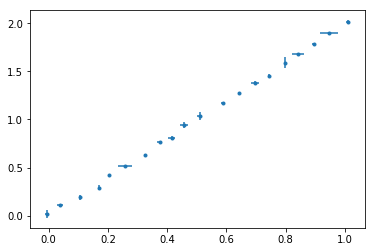

In [470]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.')
plt.show()

In [471]:
def calc_reduced_chi_square(fit, N, n_free,x, y, yerr, xerr = 0):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    if xerr is not 0:
        return 1.0/(N-n_free)*sum((fit(x) - y)**2/(yerr**2+fit.parameters[0]**2*xerr**2))
    else: 
        return 1.0/(N-n_free)*sum(((fit(x) - y)/yerr)**2)

# Using known fitters

In [472]:
linear_model = models.Linear1D()
linearlsqfitter = fitting.LinearLSQFitter() 
fit_lsq = linearlsqfitter(linear_model, x, y, weights = 1.0/y_err**2)

In [473]:
reduce_chi_squared_lsq = calc_reduced_chi_square(fit_lsq, len(x), 2, x, y, y_err, x_err)
print(reduce_chi_squared_lsq)

2.073106001724502


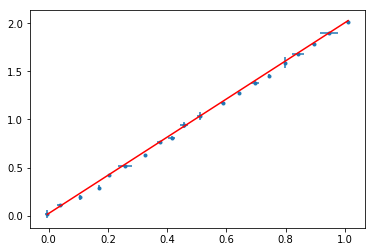

In [474]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,fit_lsq(x),'r',zorder=1)
plt.show()

# Define a Simple fitter & Statistic Function using Least absolute deviations

**Statistic Function**. Least absolute deviation is more robust. Based on [this astropy example](http://docs.astropy.org/en/stable/modeling/new.html#using-a-custom-statistic-function).

In [475]:
def lad(measured_vals, updated_model, x_sigma, y_sigma, x):
    model_vals = updated_model(x)

    return np.sum(abs(model_vals - measured_vals))

**optimizer**: Simplex and we choose **statistic**. Basic model

In [476]:
class LineFitterLAD(Fitter):
    """
    Fit a straight line with uncertainties in both variables

    Parameters
    ----------
    optimizer : class or callable
        one of the classes in optimizers.py (default: Simplex)
    """

    def __init__(self, optimizer=Simplex):
        self.statistic = lad
        super().__init__(optimizer, statistic=self.statistic)

    def __call__(self, model, x, y, x_sigma=None, y_sigma=None, **kwargs):
        """
        Fit data to this model.

        Parameters
        ----------
        model : `~astropy.modeling.core.ParametricModel`
            model to fit to x, y
        x : array
            input coordinates
        y : array
            input coordinates
        x_sigma : array
            uncertainties in x
        y_sigma : array
            uncertainties in y
        kwargs : dict
            optional keyword arguments to be passed to the optimizer

        Returns
        ------
        model_copy : `~astropy.modeling.core.ParametricModel`
            a copy of the input model with parameters set by the fitter

        """
        model_copy = _validate_model(model,
                                     self._opt_method.supported_constraints)

        farg = _convert_input(x, y)
        farg = (model_copy, x_sigma, y_sigma) + farg
        p0, _ = _model_to_fit_params(model_copy)

        fitparams, self.fit_info = self._opt_method(
            self.objective_function, p0, farg, **kwargs)
        _fitter_to_model_params(model_copy, fitparams)

        return model_copy

In [477]:
linefitterlad = LineFitterLAD() 
fit_lad = linefitterlad(model_poly, x, y, x_sigma=x_err, y_sigma=y_err)

In [478]:
reduced_chi_squared_lad = calc_reduced_chi_square(fit_lad, len(x), 2, x, y, y_err, x_err)
print(reduced_chi_squared_lad)

30.903358278173414


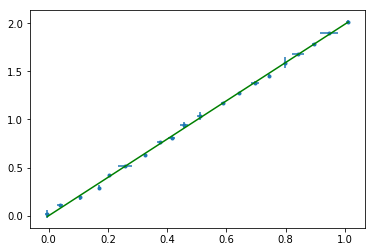

In [479]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,fit_lad(x),'g')
plt.show()

# Statistic Function using both errors

In [480]:
def chi_line(measured_vals, updated_model, x_sigma, y_sigma, x):
    """
    Chi^2 statistic for fitting a straight line with uncertainties in x and
    y.

    Parameters
    ----------
    measured_vals : array
    updated_model : `~astropy.modeling.ParametricModel`
        model with parameters set by the current iteration of the optimizer
    x_sigma : array
        uncertainties in x
    y_sigma : array
        uncertainties in y

    """
    model_vals = updated_model(x)
    if x_sigma is None and y_sigma is None:
        return np.sum((model_vals - measured_vals) ** 2)
    elif x_sigma is not None and y_sigma is not None:
        weights = 1 / (y_sigma ** 2 + updated_model.parameters[0] ** 2 *
                       x_sigma ** 2)
        return np.sum((weights * (model_vals - measured_vals)) ** 2)
    else:
        if x_sigma is not None:
            weights = 1 / x_sigma ** 2
        else:
            weights = 1 / y_sigma ** 2
        return np.sum((weights * (model_vals - measured_vals)) ** 2)

In [481]:
class LineFitterChiLine(Fitter):
    """
    Fit a straight line with uncertainties in both variables

    Parameters
    ----------
    optimizer : class or callable
        one of the classes in optimizers.py (default: Simplex)
    """

    def __init__(self, optimizer=Simplex):
        self.statistic = chi_line
        super().__init__(optimizer, statistic=self.statistic)

    def __call__(self, model, x, y, x_sigma=None, y_sigma=None, **kwargs):
        """
        Fit data to this model.

        Parameters
        ----------
        model : `~astropy.modeling.core.ParametricModel`
            model to fit to x, y
        x : array
            input coordinates
        y : array
            input coordinates
        x_sigma : array
            uncertainties in x
        y_sigma : array
            uncertainties in y
        kwargs : dict
            optional keyword arguments to be passed to the optimizer

        Returns
        ------
        model_copy : `~astropy.modeling.core.ParametricModel`
            a copy of the input model with parameters set by the fitter

        """
        model_copy = _validate_model(model,
                                     self._opt_method.supported_constraints)

        farg = _convert_input(x, y)
        farg = (model_copy, x_sigma, y_sigma) + farg
        p0, _ = _model_to_fit_params(model_copy)

        fitparams, self.fit_info = self._opt_method(
            self.objective_function, p0, farg, **kwargs)
        _fitter_to_model_params(model_copy, fitparams)

        return model_copy

In [482]:
linefitterchiline = LineFitterChiLine() 
fit_chiline = linefitterchiline(linear_model, x, y, x_sigma=x_err, y_sigma=y_err)

In [483]:
reduced_chi_squared_chiline = calc_reduced_chi_square(fit_chiline, len(x), 2, x, y, y_err, x_err)
print(reduced_chi_squared_chiline)

1.3674967217124447


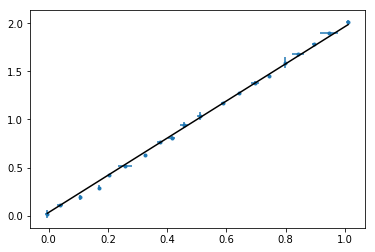

In [484]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,fit_chiline(x),'k')
plt.show()

# Comparing the three

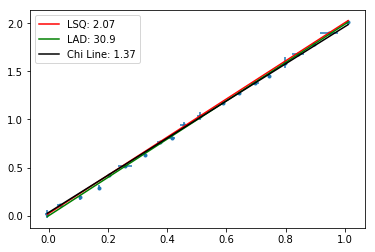

In [485]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,fit_lsq(x),'r',label='LSQ: {}'.format(round(reduce_chi_squared_lsq,2)))
plt.plot(x,fit_lad(x),'g',label='LAD: {}'.format(round(reduced_chi_squared_lad,2)))
plt.plot(x,fit_chiline(x),'k', label='Chi Line: {}'.format(round(reduced_chi_squared_chiline,2)))
plt.legend()
plt.show()

In [486]:
print(fit_lsq)
print(fit_lad)
print(fit_chiline)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.9822708319854245 0.02298044596363817
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope              intercept       
    ----------------- -----------------------
    1.989882062186355 -0.00031638236691745945
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.9305570696885028 0.03348123886995668


# Try again using the first slope we got

In [459]:
linearlsqfitter = fitting.LinearLSQFitter() 
a = fit_lsq(0)
fit_lsq_new = linearlsqfitter(linear_model, x, y, weights = 1.0/(y_err**2+a**2*x_err**2))

In [460]:
print(calc_reduced_chi_square(fit_lsq_new, len(x), 2, x, y, y_err, x_err))

9.215968311245069


In [461]:
print(fit_lsq_new)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept      
    ----------------- --------------------
    2.089611592235101 -0.05688917697919951


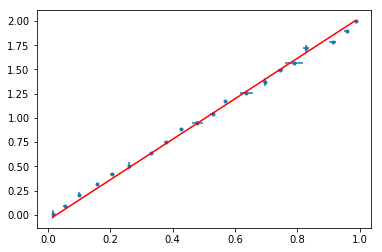

In [462]:
plt.errorbar(x,y,yerr=y_err,xerr=x_err,fmt='.',zorder=0)
plt.plot(x,fit_lsq_new(x),'r')
plt.show()